
---
<big><big><big><big><big><big>Metody uczenia maszynowego</big></big></big></big></big></big>

---



---
<big><big><big><big><big>Składanie modeli</big></big></big></big></big>

---


---

<id=tocheading><big><big><big><big>Spis treści</big></big></big></big>
<div id="toc"></div>

---


In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2.5)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

plt.style.use("fivethirtyeight")

from bokeh.io import gridplot, output_file, show
from bokeh.plotting import figure, output_notebook
from bkcharts import Scatter

In [3]:
from __future__ import print_function
from __future__ import unicode_literals
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix
from sklearn import preprocessing
from sklearn.datasets import load_boston, load_diabetes, load_linnerud, make_regression, make_blobs
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3, make_sparse_uncorrelated
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

In [4]:
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples, completeness_contamination

In [5]:
output_notebook()
sns.set(font_scale=2.5)

Loading BokehJS ...

Image inclusion
<img src="../mum_figures/" width="0%">

<img style="fill=right" src="../mum_figures/" width="0%">

# Bagging (bootstrap aggregation)
1. modelu typu __ensemble__

2. losowanie zbiorów bootstrap 
  * $N$ przykładów ze zbioru $N$ elementowego przez __losowanie ze zwracaniem__
  * prawdopodobieństwo, że przykład __nie zostanie__ wybrany w $N$ losowaniach
  $$\left(1-\frac{1}{N}\right)^N\simeq{}e^{-1}\simeq0.3678$$
  * w zbiorze bootstrap wybranych zostanie
  $$\left(1-e^{-1}\right)\simeq0.632N$$
  __różnych__ przykładów
  * daje wiele __różnych zbiorów__ danych o podobnym __rozkładzie__ odzwierciedlającym __oryginalny__ rozkład danych
3. __estymator typu _bagging___ 
$$\boxed{
\widehat{f}_{bag}(x)=\frac{1}{B}\sum_{b=1}^B\hat{f}^{*b}(x)
\;}$$

4. jeśli $\widehat{f}$ nauczona na całym zbiorze jest liniowa, to estymator bagging $\widehat{f}_{bag}$ będzie go dobrze przybliżał
  * jeśli $\widehat{f}$ nieliniowa lub silnie zależna od danych, to będą się różnić
    * poszczególne $\widehat{f}_b()$ będą popełniały błędy w __różnych__ częściach zbioru uczącego
    * klasyfikatory będą __różnorodne__ (ang. diverse)
      * różnorodne jeśli klasyfikacje różnią się na różnych częściach zbioru danych
  * estymator bagging dla drzew regresji da dobrze wygładzone wyniki

5. niech modelem  K-klasowy klasyfikator zwracający K-wymiarowy wektor 
$$[p_1(x), p_2(x),\dots,p_K(x)]$$
wtedy klasyfikator bagging da odpowiedź przez __głosowanie__
$$\boxed{\widehat{G}_{bag}(x)=\underset{k}{\arg\max}\,\widehat{f}_{bag}(x)\;}$$
6. jesli potrzebne _prawdopodobieństwo_ klasy
  * właściwe jest raczej uśrednienie wyników z poszczególnych klasyfikatorów
  * wartości zwracane przez klasyfikatory powinny być intepretowalne jako prawdopodobieństwa
  
7. analiza typu analizy błędu jako biasu i wariancji pokazuje
  * błąd z wykorzystaniem bagging jest __niższy__ niż dla __jednego__ zbudowanego na całym zbiorze danych
  * jednak dla problemów klasyfikacji bias i wariancja __nie mogą być sumowane__
    * łączenie __dobrych__ klasyfikatorów daje lepsze wyniki
    * jednak łączenie __złego__ klasyfikatora może pogorszyć wyniki!
    * jednak tzw. __słabe__ klasyfikatory bardzo dużo zyskują na składaniu

In [6]:
def bagging_classsifier_score(centers=3, n_samples=100, max_trees=20):
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=2.0)
    fig, ax = plt.subplots(figsize=(12, 10))
    cv_no = 10
    
    scores = np.zeros((max_trees, 2))
    n_range = range(1, max_trees)
    for tr in n_range:
        # we create an instance of Bagging Classifier and fit the data.
        clf = BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=3), 
                                n_estimators=tr)
        sc = cross_val_score(clf, X, y, cv=cv_no, n_jobs=-1)
        scores[tr, :] = [np.mean(sc), np.std(sc)]
    # print scores
    ax.errorbar(n_range, scores[1:, 0], scores[1:, 1])
    best_ind = np.argmax(scores[:, 0])
    print('Najlepszy wynik dla {} drzew, {:.4f} +- {:.5f} std'.format(best_ind, scores[best_ind, 0], 
                                             scores[best_ind, 1]))
    ax.set_xlabel('Liczba użytych drzew decyzyjnych', fontsize=16)
    ax.set_ylabel("Poprawność klasyfikacji", fontsize=16)
    least = np.min(scores[1:, 0] - scores[1:, 1])
    maxi = np.max(scores[1:, 0] + scores[1:, 1])
    ax.set_ylim([least - 0.005, maxi + 0.005])
    # ax.grid()

Najlepszy wynik dla 145 drzew, 0.6842 +- 0.00417 std


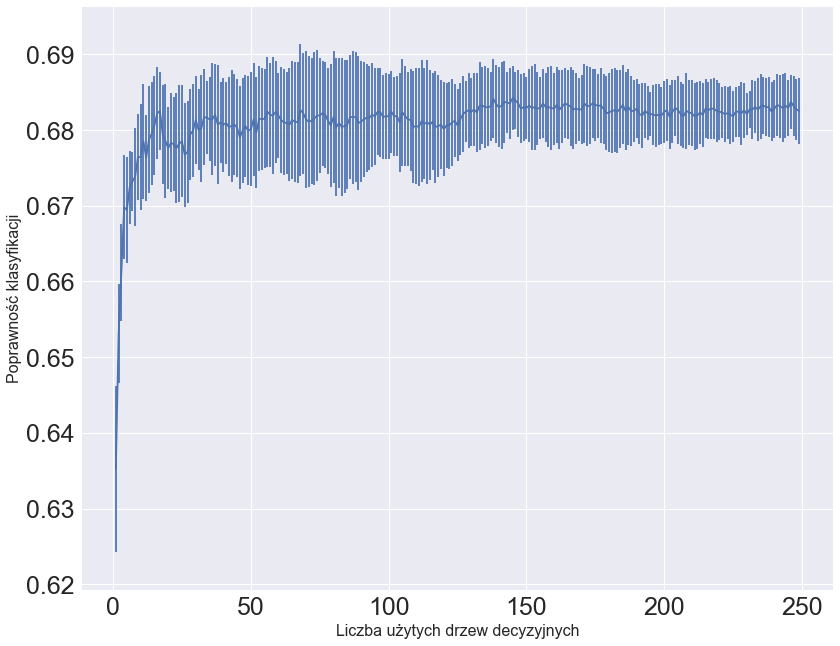

In [11]:
bagging_classsifier_score(n_samples=10000, centers=9, max_trees=250)

# Lasy drzew losowych

1. __bagging__ okazało się bardzo dobrym algorytmem
2. przez długi czas przejeło podejście __boosting__
3. __lasy drzew losowych__ (1991?)
  * duża liczb __nieskorelowanych drzew__ uśrednionych na końcu
  
4. __uśrednić__ dużą liczbę drzew zawierających dużo szumu
  * drzewa decyzyjne nadmiernie dopasowują przy głębokich drzewach
  * podział __wzdłuż osi__ układu współrzędnych __często__ nie odpowiada problemowi
  * uśrednianie i losowanie poprawia te problemy

### Budowa lasu drzew losowych

for b in range(B):
  1. wylosuj zbiór typu bootstrap $Z^{*b}$
  2. buduj drzewo losowe ze zbioru bootstrap powtarzając do osiągnięcia warunku stopu
    1. wybierz __losowo__ $m$ atrybutów spośród $p$ dostępnych
      * dla klasyfikacji typowo $m\approx\lfloor\sqrt{p}\rfloor$
      * dla regresji $m\approx\lfloor p/3\rfloor$
      * $m$ meta-parametrem
    2. spośród wybranych wybierz __najistotnijeszy__
    3. rozdziel węzeł  
    
### Aproksymacja / klasyfikacja
1. dla regresji jako średnią
2. dla klasyfikacji przez głosowanie większościowe

### Jak to działa

1. wszystkie drzewa 
  * mają __identyczny__ bias: drzewa są budowane wykorzystując te same warunki stopu
  * są bardzo __zaszumione__: ze względu na losowość wyboru atrybutów
  * uśrednianie modeli redukuje wariancję

2. istotna jest zależność między modelami
  * wszystkie modele mają taki sam rozkład i wariancję $\sigma^2$
    * uśrednione $B$ modeli ma wariancję $\sigma^2/B$
  * niech modele mają średnią korelację między sobą $\rho$
    * korelacja jest __dodatnia__
  * wariancja uśrednionych modeli ma postać $$\rho\sigma^2+\frac{1-\rho}{B}\sigma^2$$
    * jeśli  liczba modeli rośnie, to drugi skladnik zanika
    * wartość __korelacji__ modeli staje się __istotnym czynnikiem__
      * losowy wybór atrybutów __minimalizuje__ korelację między modelami!
      
3. z takiego rozrzucania danych najbardziej korzystają klasyfikatory nieliniowe
  * drzewa są liniowymi
  

In [12]:
def random_forest_score(centers=3, n_samples=100, max_trees=20):
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=2.0)
    fig, ax = plt.subplots(figsize=(12, 10))
    cv_no = 10
    
    scores = np.zeros((max_trees, 2))
    n_range = range(1, max_trees)
    for tr in n_range:
        # we create an instance of Random Forest Classifier and fit the data.
        clf = RandomForestClassifier(n_estimators=tr)
        sc = cross_val_score(clf, X, y, cv=cv_no, n_jobs=-1)
        scores[tr, :] = [np.mean(sc), np.std(sc)]
    # print scores
    ax.errorbar(n_range, scores[1:, 0], scores[1:, 1])
    ax.plot(n_range, scores[1:, 0], c='red', lw=2)
    best_ind = np.argmax(scores[:, 0])
    print('Najlepszy wynik dla {} drzew, {:.4f} +- {:.5f}'.format(best_ind, scores[best_ind, 0], 
                                             scores[best_ind, 1]))
    ax.set_xlabel('Liczba uzytych drzew decyzyjnych', fontsize=16)
    ax.set_ylabel("Poprawnosc klasyfikacji", fontsize=16)
    least = np.min(scores[1:, 0] - scores[1:, 1])
    maxi = np.max(scores[1:, 0] + scores[1:, 1])
    ax.set_ylim([least - 0.005, maxi + 0.005])
    ax.grid()

Najlepszy wynik dla 62 drzew, 0.8051 +- 0.01182


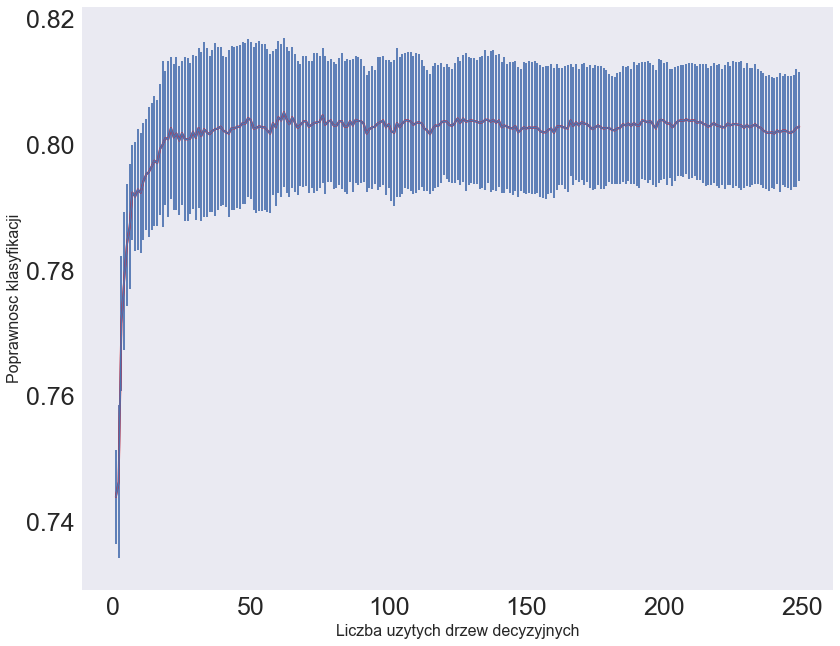

In [13]:
random_forest_score(n_samples=10000, centers=9, max_trees=250)

### Popularność
1. __olbrzymia__
  * __proste__ w użyciu
    * wymagają niewiele dopasowywania dla rozwiązania zadanego problemu
  * __szybkie__ w uczeniu
    * __ale__ potrzebują jednak zbudowania __dużej__ liczby pojedynczych drzew
2. obecnie są jednymi z najdokładniejszych klasyfikatorów
  * jednak wiele algorytmów osiąga lepsze rezultaty
  
3. jeśli problem ma wiele atrybutów i tylko __niewielki__ procent istotnych
  * wybór atrybutów istotnych staje się coraz rzadsza
  * modele typu boosting zaczynają przeważać
  
4. lasy losowe rzadko nadmiernie dopasowują się do danych

5. nazwa __random forests ®__ jest zastrzeżona do komercyjnego wykorzystania przez Salford Systems!

# Określanie przedziałów ufności dla modeli liniowych


#### wykorzystanie błędu standardowego
---
1. model liniowy z funkcjami bazowymi
  * $\Phi$ macierzą $K$ funkcji bazowych $N$ przykładów
  * aproksymacja modelem liniowym daje zestaw paramaterów modelu $\widehat{\theta}$
  * kowariancja $\widehat{\theta}$  
  $$var(\widehat{\theta})=(\Phi^T\Phi)^{-1}\widehat{\epsilon}^2$$ 
  gdzie $\widehat{\epsilon}^2$ błędem kwadratowym aproksymacji
  * dla każdego przykładu błąd standardowy jest określony przez $$\widehat{std}(\widehat{y}(x))=[\phi(x)^T(\Phi^T\Phi)^{-1}\phi(x)]^{1/2}\widehat{\epsilon}$$
  * przedział $$\widehat{y}(x)\pm 1.96 \widehat{std}(\widehat{y}(x))$$
  
  
#### wykorzystanie metodologii bootstrap
---
1. wylosowanie $B=200$ zbiorów boostrap
  * wzięcie jako przedziału 5-tej najmniejszej i 5-tej najwiekszej wartości daje przedział 95 procentowej ufności
  
  

In [14]:
def draw_bootstrap(X, y):
    select = np.random.choice(np.arange(X.shape[0]), size=X.shape[0], replace=True)
    return X[select, :], y[select]

In [15]:
class Gaussians_data():
    def __init__(self, n_gaussians=5):
        self.n_gaussians = n_gaussians
        self.basis_mu = np.zeros((n_gaussians))
        self.basis_sigma = 1.
    def gaussian_basis(self, x, mu, sigma):
        return np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    def fit_transform(self, X):
        mm = np.zeros((2, 1))
        mm[0, 0] = np.min(X)
        mm[1, 0] = np.max(X)
        ext = (mm[1, 0] - mm[0, 0]) / float(self.n_gaussians)
        mm[0, 0] -= ext /2.; mm[1, 0] += ext / 2.
        self.basis_mu = np.linspace(mm[0, 0], mm[1, 0], self.n_gaussians + 2)[1:-1]
        self.basis_sigma = 1. * (self.basis_mu[1] - self.basis_mu[0])
        # transformacja danych
        X_trans = np.zeros((X.shape[0], self.n_gaussians))
        for i in range(self.n_gaussians):
            X_trans[:, i] = self.gaussian_basis(X, self.basis_mu[i], 
                                                self.basis_sigma).reshape((X.shape[0],))
        return X_trans
    def transform(self, X):
        X_trans = np.zeros((X.shape[0], self.n_gaussians))
        for i in range(self.n_gaussians):
            X_trans[:, i] = self.gaussian_basis(X[:, 0], self.basis_mu[i], 
                                                self.basis_sigma).reshape((X.shape[0],))
        return X_trans
    def get_params(self):
        return self.basis_mu, self.basis_sigma

In [16]:
def bootstrap_inference(n_gaussians=5, n_exmpl=100, std=0.1, bootstrap_runs=10):
    left = -1.0; right = 1.0
    X = np.array(sorted(np.random.uniform(left, right, size=n_exmpl))).reshape((n_exmpl, 1))
    noise = np.random.normal(loc=0.0, scale=std, size=n_exmpl)
    y = 2. * X ** 4 + 6.5 * X ** 3 + 0.5 * X ** 2 - 4. * X 
    y = y + noise.reshape((n_exmpl, 1))
    y = y.reshape((n_exmpl, ))
    fig, ax = plt.subplots(3, 1, figsize=(16, 22))
    ax[0].plot(X, y, '.', ms=12, c='red')
    gd = Gaussians_data()
    X_trans = gd.fit_transform(X)
    lr = SGDRegressor(max_iter=10000)
    lr.fit(X_trans, y)
    x_test = np.linspace(left, right, n_exmpl).reshape((n_exmpl, 1))
    x_test_trans = gd.transform(x_test)
    y_lr_pred = lr.predict(x_test_trans)
    ax[0].plot(x_test, y_lr_pred, c='black', lw=4)
    # oblicz 95% granice zaufania
    xtxi = np.linalg.inv(np.dot(X_trans.T, X_trans))
    y_pred = lr.predict(X_trans)
    var = np.sum((y - y_pred) ** 2) / y.shape[0]
    se = np.zeros((y.shape[0]))
    varsqrt = np.sqrt(var)
    # oblicz błędy standardowe dla przykładów
    for i in range(y.shape[0]):
        se[i] = np.sqrt(np.dot(np.dot(X_trans[i].T, xtxi), X_trans[i])) * varsqrt
    upper = y_pred + 1.96 * se
    lower = y_pred - 1.96 * se
    ax[0].plot(X, upper, '--k', lw=2)
    ax[0].plot(X, lower, '--k', lw=2)
    ax[0].fill_between(X.reshape((-1)), lower, upper, facecolor="pink", alpha=0.2)
    ax[0].set_xlim([left, right])
    
    # wylosuj zbiory bootstrap i oblicz dla nich predykcje
    ax[1].plot(X, y, '.', ms=12, c='red')
    res = np.zeros((bootstrap_runs, y.shape[0]))
    for b in range(bootstrap_runs):
        X_b, y_b = draw_bootstrap(X, y)
        gd = Gaussians_data(n_gaussians=n_gaussians)
        X_b_trans = gd.fit_transform(X_b)
        lrg = SGDRegressor(max_iter=5000)
        lrg.fit(X_b_trans, y_b)
        X_trans = gd.transform(X)
        res[b, :] = lrg.predict(X_trans)
        X_test_trans = gd.transform(x_test)
        y_test_lrg_pred = lrg.predict(X_test_trans)
        # res[b, :] = y_test_lrg_pred
        ax[1].plot(x_test, y_test_lrg_pred, alpha=0.3)
    ax[1].set_xlim([left, right])
    # wybierając 5-tą najwyższą i 5-tą najniższą wartość określamy 95%
    # granice zaufania
    res_sorted = np.sort(res, axis=0)
    ax[2].plot(X, y, '.', ms=12, c='red')
    shift = int(np.floor(0.05 * bootstrap_runs / 2))
    ax[2].plot(X, res_sorted[shift - 1, :], '--k', lw=2)
    ax[2].plot(X, res_sorted[bootstrap_runs - shift], '--k', lw=2)
    ax[2].fill_between(X.reshape((-1)), res_sorted[shift -1, :], 
                       res_sorted[bootstrap_runs - shift], facecolor='pink', alpha=0.2)
    ax[2].set_xlim([left, right])
    # rozwiązanie bootstrap aggregation (bagging)
    bag = np.mean(res, axis=0)
    ax[2].plot(X, bag, c='red', lw=4, label='Bagging')
    ax[2].plot(x_test, y_lr_pred, '--', c='black', lw=4, label='Oryginalne')
    ax[2].legend(loc=0)
    fig.tight_layout()

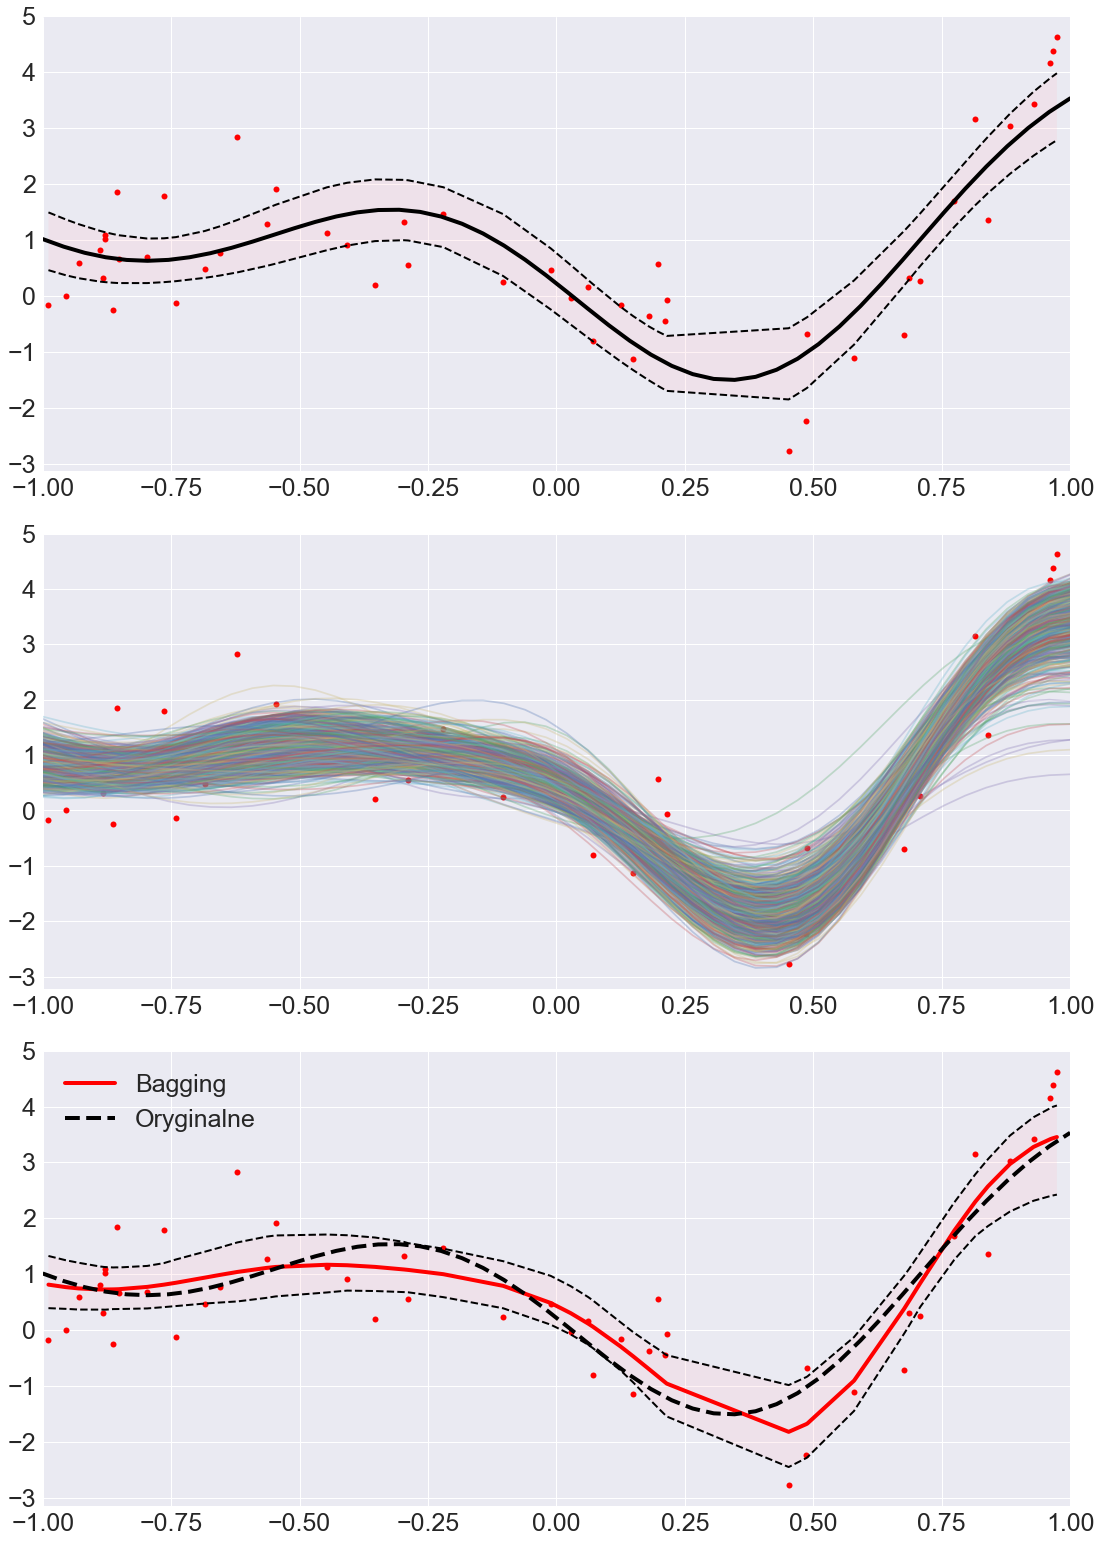

In [17]:
bootstrap_inference(n_gaussians=7, n_exmpl=50, std=0.75, bootstrap_runs=1000)

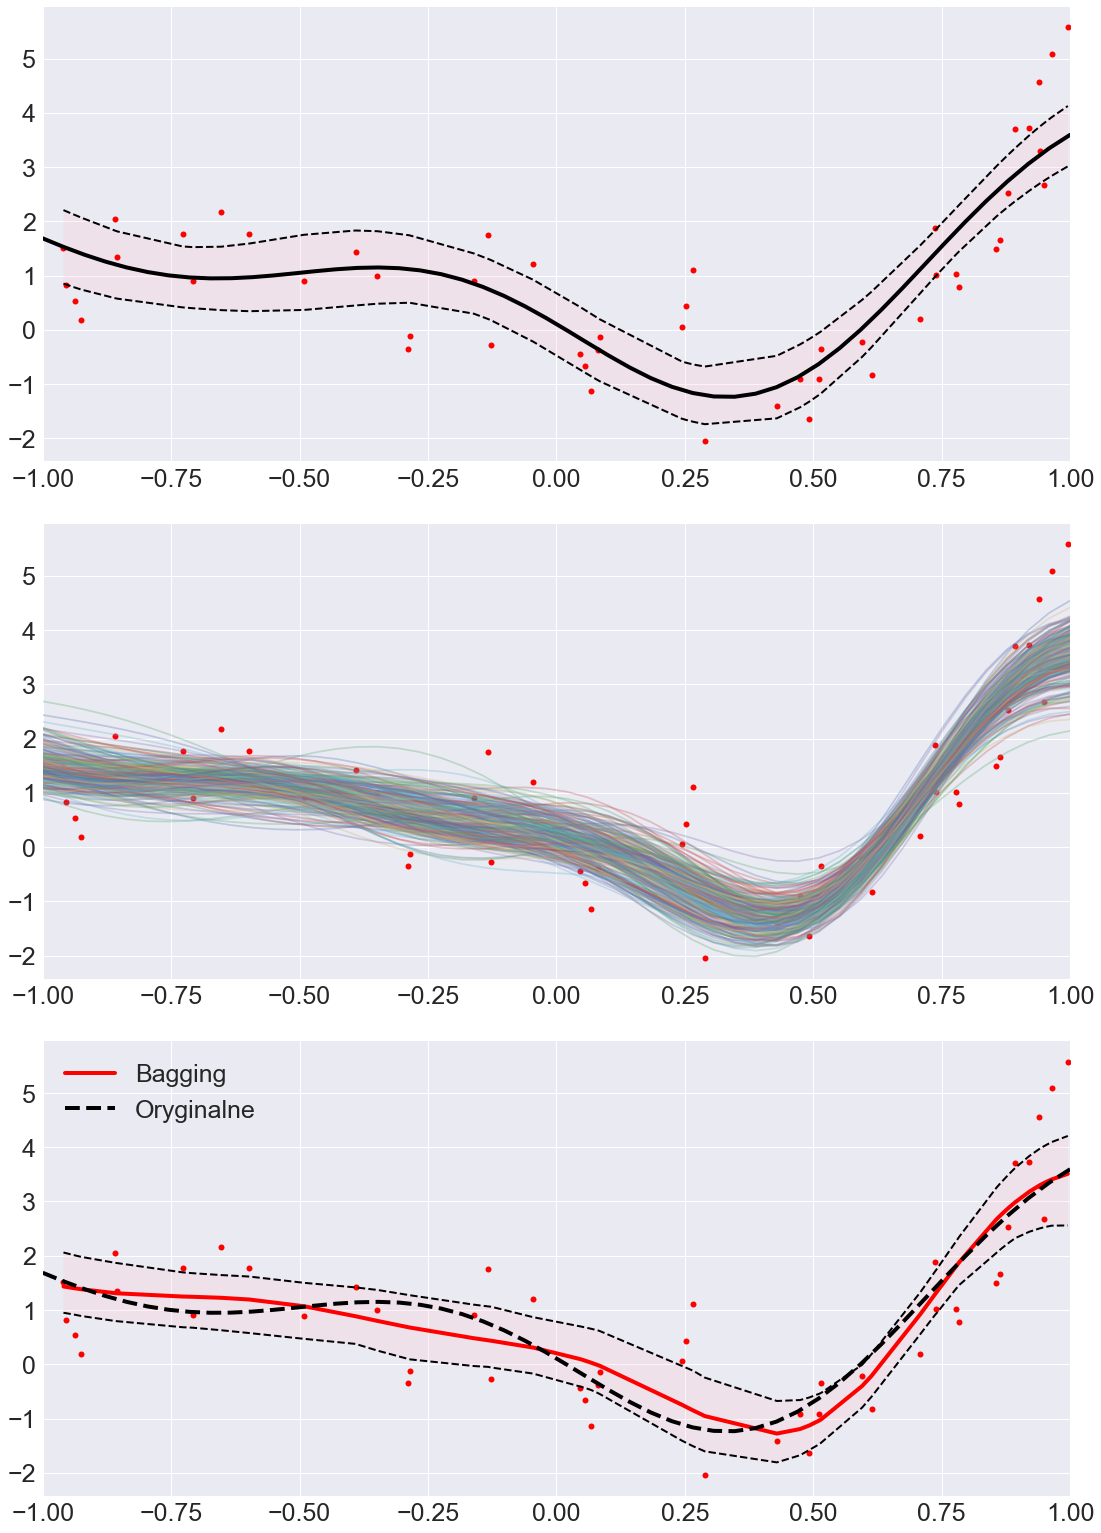

In [18]:
bootstrap_inference(n_gaussians=7, n_exmpl=50, std=0.75, bootstrap_runs=250)

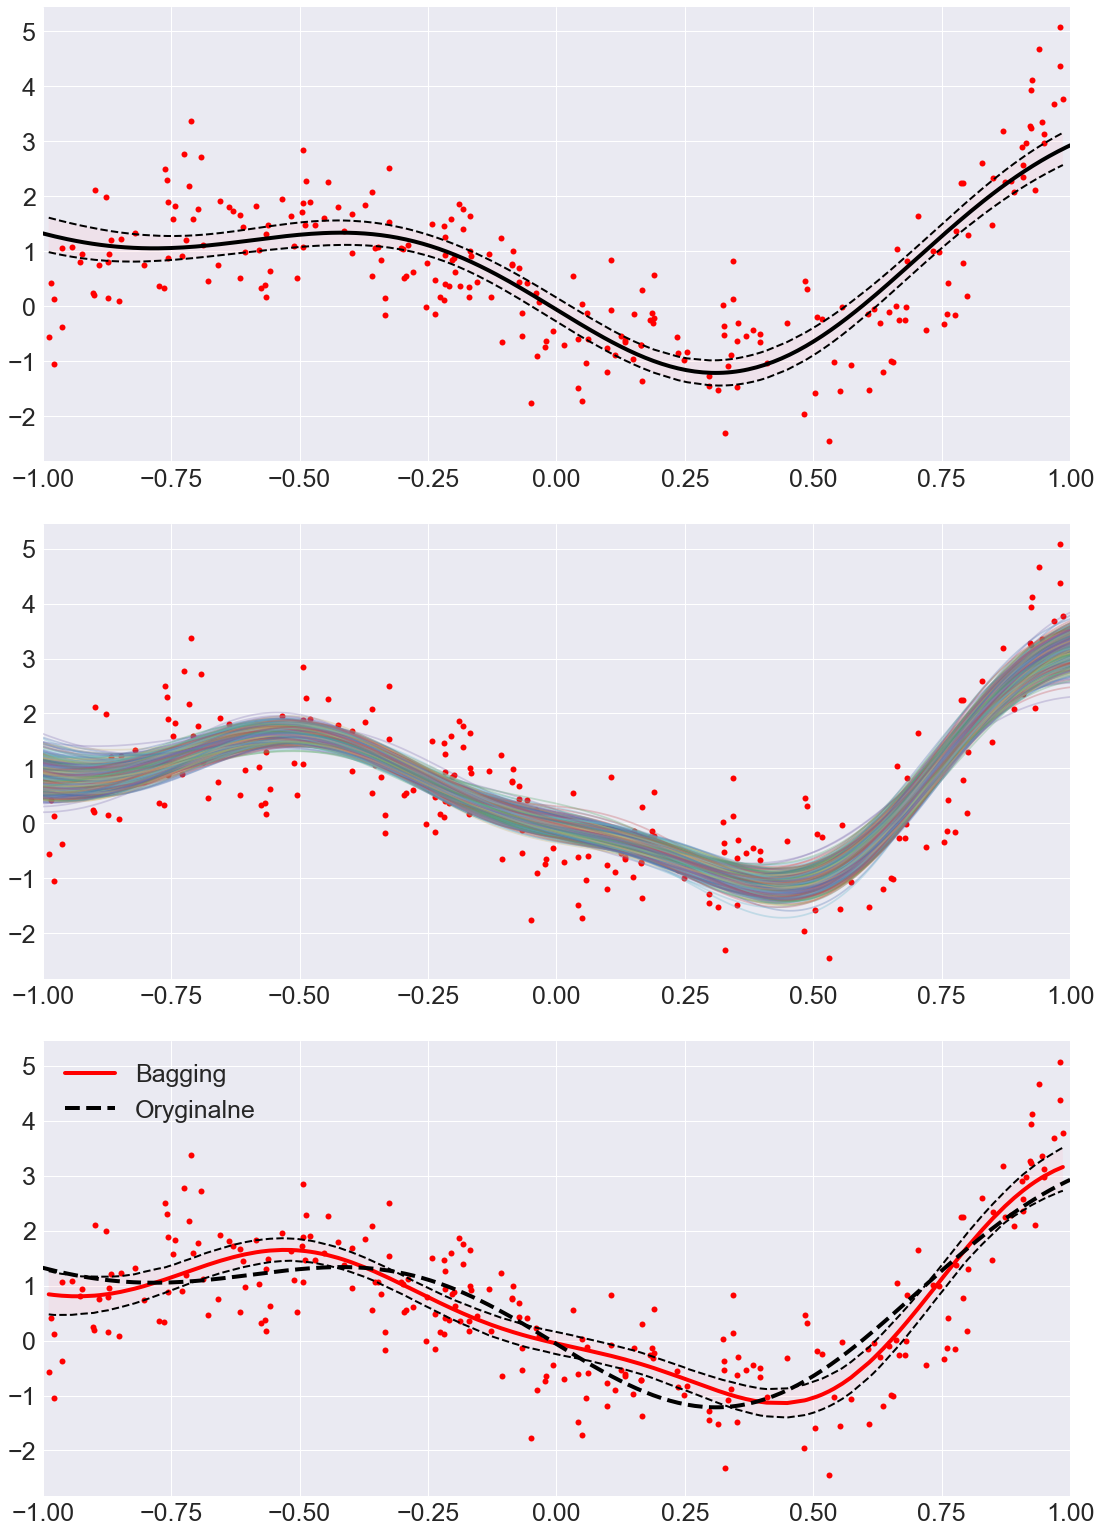

In [19]:
bootstrap_inference(n_gaussians=7, n_exmpl=250, std=0.75, bootstrap_runs=1000)

# Uśrednianie modeli

1. bagging redukuje błąd kwadratowy
2. inne sposoby __składania__
  * $K$ modeli $\mathcal{M}_k\;k=1,\dots,K$ dla danych $D$
  * modele
    * __tego samego typu__ ale z __różnymi__ parametrami
    * __różnych typów__ dla __tego samego__ zadania
3. niech $z$ interesującą wartością (predykcją w punkcie x, statystyką, etc.)
  $$P(z\mid D)=\sum_{k=1}^K P(z\mid\mathcal{M}_k,D)\,P(\mathcal{M}_k\mid D)$$
  z wartością oczekiwaną
  $$E(z\mid D)=\sum_{k=1}^K E(z\mid\mathcal{M}_k,D)\,P(\mathcal{M}_k\mid D)$$

4. predykcja  
  * __ważona__ średnią pojedynczych predykcji 
  * __proporcjonalna__ do prawdopodobieństwa każdego modelu (zależnego od zbioru danych, _posterior_)

## Komitety maszyn
---
1. __Komitety maszyn__ biorą __prostą średnią__ (z równym prawdopodobieństwem modeli)
  * użyć miary oceniającej prawdopodobieństwo/jakość modelu
    * jeśli preferowane modele mniej złożone to użyc np. miary __BIC__ (__Bayesian Information Criterion__)
  $$BIC=\frac{N}{\sigma_{\epsilon}^2}\sum_i(y_i-\widehat{f}(x_i))^2+(\log N)d$$
  gdzie $d$ liczbą __parametrów__ modelu 
      * liczbą funkcji bazowych
      * liczbą parametrów (wag) modelu, etc.
2. uśrednianie modeli __nigdy__ nie pogarsza wyników
  * w każdym razie dla estymacji na pełnym rozkładzie danych
    * ale ten nie jest dostępny
  * w każdym razie dla regresji
    * zwykle zabezpiecza przed złym łączeniem wzięcie pod uwagę złożoności modeli
3. dla klasyfikacji konieczne jest, by __nie__ uśredniać modeli __złych__
  * __modele słabe__: intuicyjnie __trochę__ lepsze od losowych

# Modele addytywne

2. model __addytywny__
$$y_i=\beta_0+f_1(x_{i1})+f_2(x_{i2})+\dots+f_p(x_{ip})+\epsilon_i\hskip2emi=1,\dots,N$$
  * z ograniczeniami $\mathrm{E}[y_i]=\beta_0\hskip2em \mathrm{E}[f_j(x_{ij})]=0$
  * $x_{\cdot j}$ atrybuty wyjaśniające
  * modele addytywne mają
    * __niższą wariancję__ niż modele bezparametryczne, np. modele __k-sąsiadów__
    * __niższy bias__ niż modele parametryczzne, np. regresja liniowa
  * tracimy wpływ __zależności między atrybutami__ na wynik
    * można _ręcznie_ dodać zależności typu $f_{jk}(x_{\cdot j},x_{\cdot k})$
2. wystarczy przestawić elementy by uzyskać algorytm tzw. __backfitting__
  $$y_i-\beta_0-\sum_{k\neq{}j}f_k(x_{ik})=f_j(x_{ij})+\epsilon_i\hskip2em i=1,\dots,N$$
  1. $\widehat\beta_0=\overline{y}-\frac{1}{N}\sum_{i=1}^Ny_i$
  2. pętla po $j=1,\dots,p$
    1. wyliczenie __residuum__
    $$y^{(j)}=y-\widehat\beta_0-\sum_{k\neq{}j}f_k(x_{\cdot k})$$
    gdzie $x_{\cdot k}$ jest wektorem wszystkich $N$ wartości atrybutu $k$
    2. wyliczenie nowego $\widehat{f}_j$
    $$\widehat{f}_j=S(x_{\cdot k}, y^{(j)})$$
    gdzie $S()$ jest ustaloną klasą funkcji, w szczególności __jednowymiarowych gładkich__
      * dla różnych zmiennych można użyć __różnych__ klas funkcji
    3. wycentrowanie $\widehat{f}_j$
    $$\widehat{f}_j=\widehat{f}_j-\frac{1}{N}\sum_{i=1}^N\widehat{f}_j(x_{ij})$$
  3. powtarzając do momentu w którym $\widehat{f}_j$ nie będą się zmieniać więcej niż jakiś próg
2. regresja logistyczna dla problemu binarnego
$$\log\left(\frac{y(X)}{1-y(X)}\right)=\beta_0+\theta_1X_1+\dots+\theta_L X_p,$$
gdzie $y(X)=P(Y=1|X)$

3. __addytywna__ regresja logistyczna będzie miała postać
$$\log\left(\frac{y(X)}{1-y(X)}\right)=\beta_0+f_1(X_1)+\dots+f_L(X_p)$$

# Boosting
1. wiele __słabych__ klasyfikatorów bazowych dla modelu o dobrej zdolności predykcji
2. __słaby klasyfikator__ ma oczekiwany błąd jest __niewiele lepszy__ od klasyfikatora losowego
3.  niech $G()$ będzie binarnym klasyfikatorem i 
$$err=\frac{1}{N}\sum_{i=1}^NI(y_i\neq G(x_i)$$
będzie jego błędem nauczania

4. __Boosting__ buduje sekwencję $G_k(x)$ słabych klasyfikatorów 
  * do __modyfikowanych danych__ dodaje predykcję
$$\boxed{
G(x)=sign\left(\sum_{k=1}^K\alpha_kG_k(x)\right)
\;}$$
  * $\alpha_k$ __wagami__ słabych klasyfikatorów odpowiadającymi ich __dokładności__
  * zbiory danych modyfikowane by __skupić uczenie__ na przykładach trudniejszych
    * uczenie przez __modyfikację rozkładu danych__
  * modele bazowe stają się __ekspertami__ dla pewnych podobszarów danych

## algorytm uczenia AdaBoost.M1

1. inicjalizacja __wag przykładów__ na $w_i=1/N$
2. for $k$ in range($K$):
  1. klasyfikator $G_k(x)$ dla danych z wagami $w_i$
    * przykłady w trakcie uczenia są __losowane__ zgodnie z rozkładem wag $w$
  2. aktualny błąd uczący $G_k()$ $$err_k=\frac{\sum_{i=1}^Nw_iI(y_i\neq G_k(x_i))}{\sum_{i=1}^Nw_i}$$
  3. współczynnik __istotności__ $\alpha_k$ modelu 
  $$\alpha_k=\ln\left(\frac{1-err_k}{err_k}\right)$$ jako funkcję __logit__
  4. wagi przykładów $$w_i=w_i\cdot\exp(\alpha_k\cdot I(y_i\neq G_k(x_i)))$$
    * jeśli $x_i$ był __źle rozpoznawany__ przez $G_k()$, to waga $x_i$ jest zwiększana
    * jeśli $x_i$ był poprawnie rozpoznawany, to waga jest zmniejszana
    * wektor wag jest znormalizowany
3. model końcowy $$G(x)=sign\left[\sum_{k=1}^K\alpha_k G_k(x)\right]$$

4. nawet bardzo słabe klasyfikatory mogą dać do wysoką skuteczność modelu
5. AdaBoost modelem 
  * __addytywnym__
  * __krokowym__ bo w każdym etapie optymalizuje tylko ze względu jedną parę parametrów, tj. $\alpha_k, G_k$ 
  * __zachłannym__ bo nie __nie zmienia__ poprzednich $\alpha_j, G_j;\;\;j=1,\dots,k-1$
  * lepszy byłby model optymalizujący wszystkie $G_k$ 
    * zbyt złożony problem optymalizacyjny

In [51]:
def adaboost(n_samples=500, max_depth=1):
    Xa, ya = make_gaussian_quantiles(mean=(1, 1), cov=1.5, n_samples=n_samples, 
                                     n_features=2, n_classes=2)
    Xb, yb = make_gaussian_quantiles(mean=(2, 3), cov=2.0, n_samples=n_samples, 
                                     n_features=2, n_classes=2)
    X = np.concatenate((Xa, Xb))
    y = np.concatenate((ya, -yb +1))
    fc = (y > 0)
    sc = (y < 1)
    fig, ax = plt.subplots(figsize=(14, 12))
    my_cmap = sns.light_palette("Navy", as_cmap=True)
    ax.plot(X[fc, 0], X[fc, 1], '.', ms=10)    
    ax.plot(X[sc, 0], X[sc, 1], '.', ms=10)
    
    tree = DecisionTreeClassifier(max_depth=max_depth)
    # dummy = DummyClassifier(strategy='prior')
    adab = AdaBoostClassifier(tree, n_estimators=250)
    adab.fit(X, y)
    
    h = 0.025
    ext = 0.25
    x_min, x_max = X[:, 0].min() - ext, X[:, 0].max() + ext
    y_min, y_max = X[:, 1].min() - ext, X[:, 1].max() + ext
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = adab.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=my_cmap)

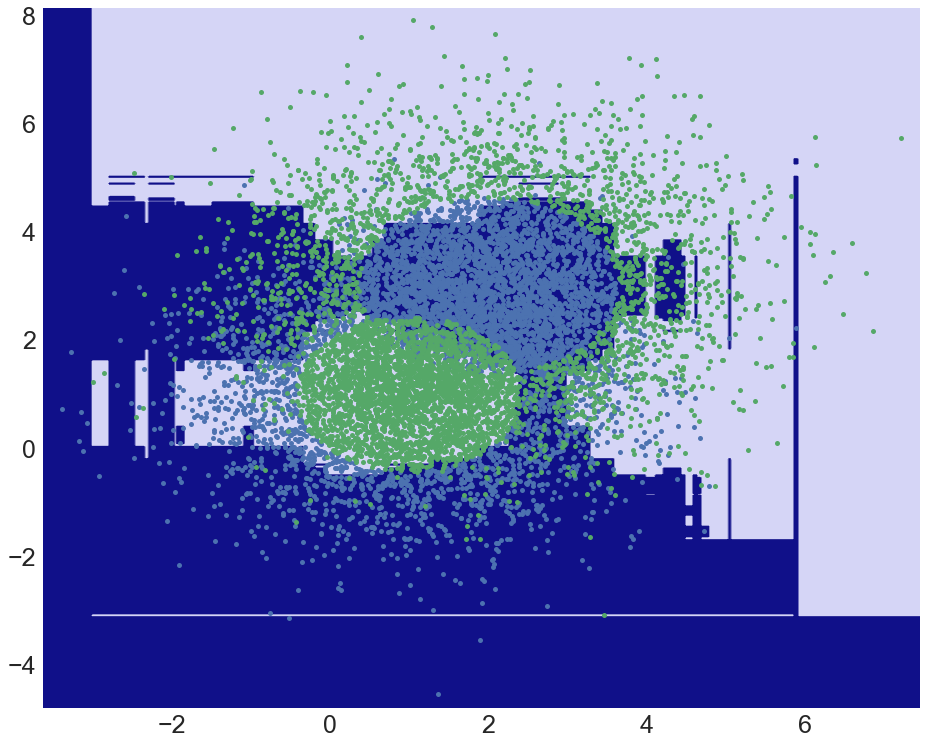

In [52]:
adaboost(n_samples=5000, max_depth=1)

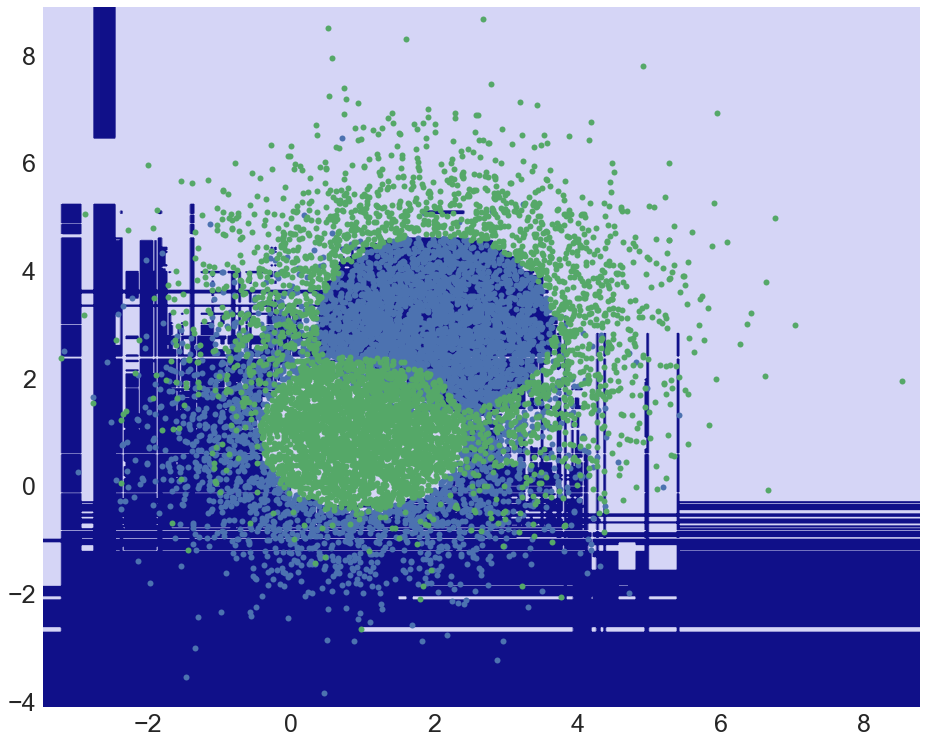

In [33]:
adaboost(n_samples=5000, max_depth=2)

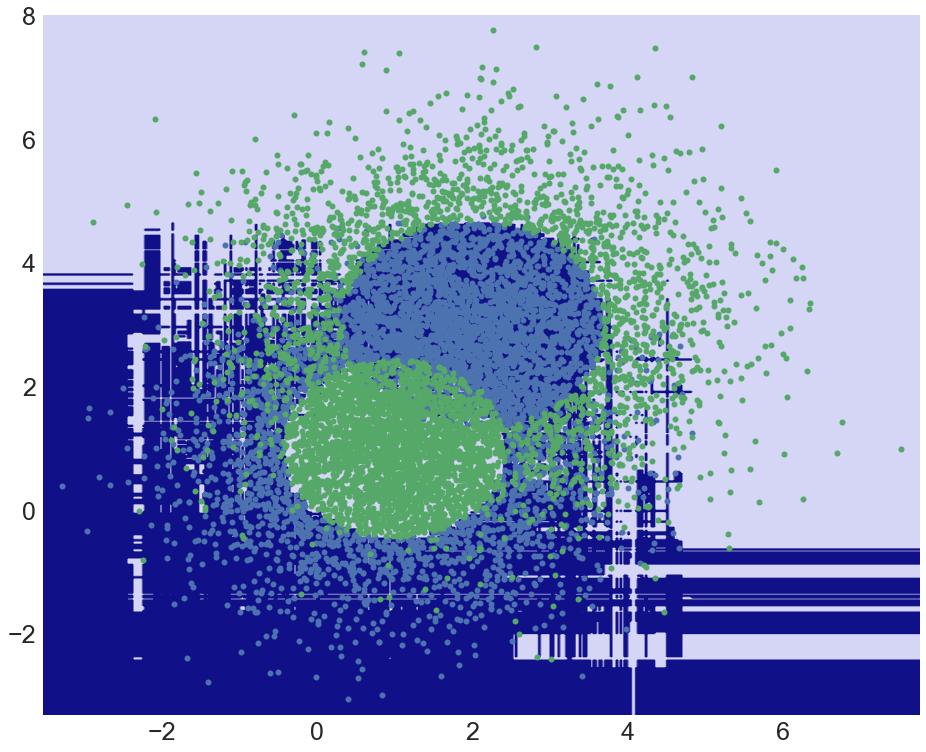

In [34]:
adaboost(n_samples=5000, max_depth=3)

## Adaboost


1. Adaboost jest modelem __addytywnym__
  * w kolejnych krokach buduje zestaw __funkcji bazowych__ 
  * popularne w 
    * sieciach neuronowych: __cechy__ wykrywane w warstwach ukrytych
    * przetwarzaniu sygnałów: kolejno budowane funkcje w oparciu o funkcje falkowe, 
    * drzewach decyzyjnych: wybierane testy
2. algorytm  
  1. inicjalizacja $f_0(x)=0$
  2. dla kolejnych modeli $k=1,\dots,K$
    1. $$(\beta_k, \theta_k)=\underset{\beta,\theta}{\arg\min}\sum_{i=1}^NL(y_i, f_{k-1}(x_i)+\beta h(x_i;\theta)),$$
    gdzie $h(x_i;\theta)$ jest funkcją __bazową parametryzowaną $\theta$__
    2. $$f_k(x)=f_{k-1}(x)+\beta_k h(x;\theta)$$
  
3. dla błędu kwadratowego w kolejnym kroku poprawiania
$$\begin{align}
L(y_i, f_{k-1}(x_i)+\beta h(x_i;\theta))&=(\underbrace{y_i-f_{k-1}(x_i)}_{residuum}-\beta h(x_i;\theta))^2\\
&=(r_{ik}-\beta h(x_i;\theta))^2
\end{align}$$
  * krok __minimalizuje residuum__ błędu aktualnego $(k-1)$-szego modelu!
    * oczywiście błąd kwadratowy nie jest najlepszym wyborem dla klasyfikacji

## Funkcja kosztu w  Adaboost

1. Adaboost.M1 jest __równoważny__ algorytmowi krokowego addytywnego modelowania dla funkcji kosztu __exponential loss__
$$\boxed{L(y, f(x))=\exp(-yf(x))\;}$$
2. używając eksponencjalnej funkcji loss dostajemy do minimalizacji w kroku addytywnego algorytmu
$$\begin{align}
(\beta_k,G_k)&=\underset{\beta,G}{\arg\min}\sum_i^N\exp[\overbrace{-y_i(f_{k-1}(x_i)}^{\substack{\text{residuum}\\\text{exponential loss}}}+\beta G(x_i))]\\
&=\underset{\beta,G}{\arg\min}\sum_i^N\exp[-y_if_{k-1}(x_i)]\exp[-\beta y_i G(x_i))]\\
&=\underset{\beta,G}{\arg\min}\sum_i^Nw_i^{(k)}\exp[-\beta y_i G(x_i))]\tag{*}\\
\end{align}$$
gdzie $w_i^{(k)}=\exp[-y_if_{k-1}(x_i)]$ jest niezależne od $\beta$ i $G$

3. optymalne $G$ jest to, które popełnia __najmniej__ błędów na __zbiorze ważonym przez $w_i^{(k)}$__
$$G_k=\underset{\beta,G}{\arg\min}\sum_i^Nw_i^{(k)}I(y_i\neq G(x_i))$$
  * w tym kroku $\alpha$ jest traktowane jako ustalone i minimalizowany jest model ze względu na funkcję bazową $G$
  * wagi $w$ __nie zależą__ od $\alpha$ ani od $G$, stąd traktowane są jako związane z przykładami
  
4. rozbijając $(*)$ na przykłady dobre/złe klasyfikacje ($y_i\in\{-1,+1\}$)
$$\begin{align}
&\sum_i^Nw_i^{(k)}\exp[-\beta y_i G(x_i))]\\
=&\overbrace{\sum_{y_i=G(x_i)}w_i^{(k)}\exp(-\beta)}^{\text{poprawne: } y_iG(x_i)=+1}
+\overbrace{\sum_{y_i\neq G(x_i)}w_i^{(k)}\exp(\beta)}^{\text{niepoprawne:  }y_iG(x_i)=-1}\tag{**}\\
=&e^{-\beta}\sum_{y_i=G(x_i)}w_i^{(k)}+
\overbrace{e^{-\beta}\sum_{y_i\neq{}G(x_i)}w_i^{(k)}-e^{-\beta}\sum_{y_i\neq{}G(x_i)}w_i^{(k)}}^{\text{dodane i odjęte dla niepoprawnych klasyfikacji}}
+e^{\beta}\sum_{y_i\neq{}G(x_i)}w_i^{(k)}\\
=&\left[e^{-\beta}\sum_{y_i=G(x_i)}w_i^{(k)}+e^{-\beta}\sum_{y_i\neq{}G(x_i)}w_i^{(k)}\right]
\left[+e^{\beta}\sum_{y_i\neq{}G(x_i)}w_i^{(k)}-e^{-\beta}\sum_{y_i\neq{}G(x_i)}w_i^{(k)}\right]\\
=&e^{-\beta}\sum_{i=1}^Nw_i^{(k)}+[e^{\beta}-e^{-\beta}]\sum_{i=1}^Nw_i^{(k)}I(y_i\neq{}G(x_i))
\end{align}$$
  * w pierwszym składniku kara $e^{-\beta}$ odnosi się do wszystkich przykladow i nie ma wplywu na rozwiązanie
  * w drugim składniku mamy karę dla przykladów źle klasyfikowanych
    * $I(y_i\neq{}G(x_i))=1$ dla błędnych, i $0$ dla poprawnych klasyfikacji
  
5. równanie (**) można zapisać jako 
$$e^{-\beta}(1-err)+e^{\beta}err$$ 
gdzie $err_k$ jest ważonym błędem klasyfikatora $G_k$  
  * jakie $\beta$?
  $$\begin{align}
  \frac{\partial}{\partial\beta}\left(-e^{-\beta}(1-err)+e^{\beta}err\right)&=\\
  -e^{-\beta}(1-err)+e^{\beta}err&=0\\
  -(1-err)+e^{2\beta}err&=0\\
  \exp({2\beta})&=\frac{1-err}{err}
  \end{align}$$
  skąd optymalne $\alpha_k$ i $\beta_k$ 
$$\boxed{\alpha_k=2\beta_k=\ln\frac{1-err_k}{err_k}}$$ 
* nowe wagi przykladów mają postać
$$\boxed{w_i^{(k+1)}=w_i^{(k)}\cdot{}\exp(\alpha_kI(y_i\neq{}G_k(x_i)))\cdot{}\exp(-\beta_k)\;}$$
  * przykłady __źle__ zaklasyfikowane mają __zwiększaną__ wagę razy czynnik $\exp(\alpha_k)$
  * $e^{-\beta}$ jest czynnikiem __normalizującym__

6. Yoav Freund i Robert Schapire otrzymali nagrodę G$\:{o}$dla za propozycję tego algorytmu w 2003 roku

In [53]:
def loss_functions():
    fig, ax = plt.subplots(figsize=(16, 12))
    x = np.linspace(-2.0, 2.0, 1000)
    misclass = np.sign(-x) / 2. + 0.5
    exp_loss = np.exp(-x)
    c = 1./np.log(1.+np.exp(-0))
    binom = c * np.log(1. + np.exp(-2 * x))
    squared = (1. - x) ** 2
    svm = np.maximum(0, (1. - x))
    ax.plot(x, misclass, label=r'błędna klasyfikacja')
    ax.plot(x, exp_loss, label='eksponencjalna')
    ax.plot(x, binom, label='binomialna')
    ax.plot(x, squared, label='kwadratowa')
    ax.plot(x, svm, label='svm')
    ax.set_xlim([-2., 2.])
    ax.set_ylim([0, 6.0])
    ax.legend(loc=0)

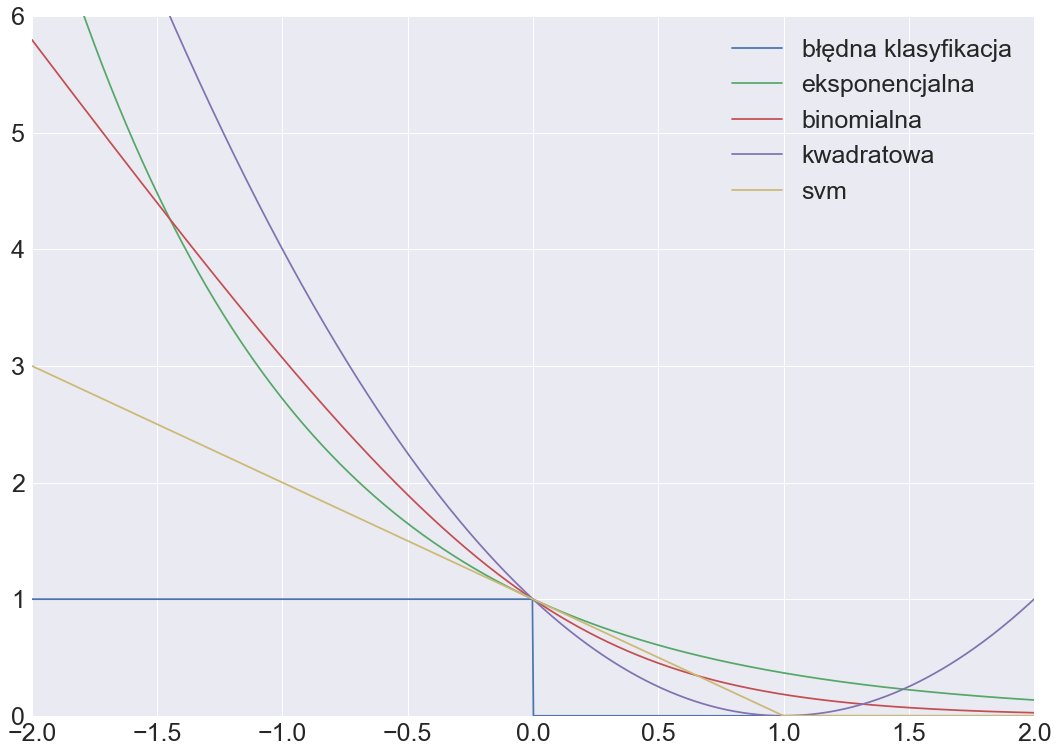

In [54]:
loss_functions()

## Funkcje kosztu
1. czemu __eksponencjalna funkcja__ kosztu?
  * dla binarnego ($y\in\{-1,+1\}$)
  $$\begin{align}
  L[exp(-yf(x)]=&P(y=-1\mid x)\,exp(-f(x))\\
  &+P(y=+1\mid x)\,exp(f(x))
  \end{align}$$
  * różniczkując __ze względu na $f$__ dostajemy optymalne $f^{*}$
  $$\begin{align}
  \exp(-f(x))f'(x)p(y=-1\mid x)&+\exp(f(x))f'(x)p(y=+1\mid x)=0\\
  \frac{\exp(-f(x))}{\exp(f(x))}&=-\frac{P(y=+1\mid x)}{P(y=-1\mid x)}\\
  f(x)&=\frac{1}{2}\ln\frac{P(y=+1\mid x)}{1-P(y=+1\mid x)}
  \end{align}$$
  $$\boxed{f^{*}(x)=\underset{f}{\arg\min}\,L[exp(-yf(x))]=\frac{1}{2}\ln\frac{P(y=+1\mid x)}{P(y=-1\mid x)}\;}$$
  gdzie składnik $\displaystyle \ln\frac{P(y=+1\mid x)}{P(y=-1\mid x}$ jest znany jako __log-odds__

2. eksponencjalna funkcja loss pozwala na prostą metodę modyfikacji wag modelu
3. addytywny model Adaboost  estymuje log-odds $P(Y=1\mid X)$ $$f^{*}(x)=\frac{1}{2}\ln\frac{P(Y=1\mid X)}{1-P(Y=1\mid X)}$$

4. pojęcie __marginesu__
  * __dodatni__ dla $y_if(x_i)>0$
  * __ujemny__ dla $y_if(x_i)<0$
  * punkty źle klasyfikowane (z marginesu ujemnego)) są karane silniej niż te klasyfikowane poprawnie (margines dodatni)
5. podobnie funkcja binomialna $$L(Y,f)=\log(1+\exp(-2yf))$$
  
6. eksponencjalna $\log(-yf(x))$ i binomialna $\log(1+\exp(-2yf(x))$ karzą dla negatywnego marginesu
  * stopień w jakim eksponencjalna funkcja karze przykłady źle klasyfikowane i odległe od płaszczyzny jest __wykładniczo__ wysoki
    * szum, outliers, mają zbyt duży wpływ na postać rozwiązania
  * binomialna robi to w mniejszym stopniu
    * wzrost wartości karzącej dla ujemnego marginesu jest prawie liniowy
    * ta funkcja należy do kategorii funkcjii __odpornych na szum__
    * optymalizacja bardziej złożona i wymaga metod gradientowych
  * skuteczność Adaboost spada w przypadku dużego szumu
    * szczególnie dla błędnych etykietowań

### Rozszerzenia i uwagi do Adaboost
* istnieją rozszerzenia dla problemów wieloklasowych
* także zastosowanie regularyzacji


* co ciekawe, gdy błąd Adaboost maleje do zera, algorytm jest typowo __odporny
na przeuczenie__!
  * to wciąż żywy obszar badań

### Siła różnych modeli (według Hastie et al.)

|   | Sieci neuronowe | SVM | Drzewa | k-NN, metody jądrowe  |
|---|---|---|---|---|
| dane różnych typów | -- | -- | ++  | --  |
| przetwarzanie brakujących zmiennych | -- | -- | ++ | ++ |
| odporność na outliers | -- | -- | ++ | ++ |
| odporność na monotoniczne transformacje dnaych | -- | -- | ++ | -- |
| skalowalność obliczeń | -- | -- | ++ | -- |
| zdolność przetwarzania nieistotnych zmiennych | -- | ++ | ++ | -- |
| zdolność ekstrakcji kombinacji liniowych cech | ++ | ++ | -- | oo |
| interpretowalność | -- | -- | oo | -- |
| siła generalizacji | ++ | ++ | -- | ++ |

